<a href="https://colab.research.google.com/github/akimi-yano/yoga-posture-classification/blob/main/Repro_Of_Yoga_Posture_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Summary

This Google Colab is a repro of this Kaggle notebook code: https://www.kaggle.com/code/vencerlanz09/yoga-pose-classification-using-cnn-mobilenetv3/notebook which implements the Yoga Posture Classification using CNN and MobileNetV3Large (Transfer Learning). The original dataset can be found here: https://www.kaggle.com/datasets/tr1gg3rtrash/yoga-posture-dataset/data

# Import Libraries

In [ ]:
# Google Drive
from google.colab import drive

# Basic libraries for data science
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Python libraries
import itertools
import random

# Visualization libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Image processing
import cv2

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model

# System libraries
import os
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
# Mount the data
drive.mount('/content/drive')
path = '/content/drive/MyDrive/yoga_pose_dataset'
val = os.listdir(path)
print(val)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['Poses.json', 'Adho Mukha Vrksasana', 'Virabhadrasana Two', 'Parsvottanasana', 'Eka Pada Rajakapotasana', 'Bitilasana', 'Balasana', 'Urdhva Mukha Svsnssana', 'Marjaryasana', 'Dhanurasana', 'Alanasana', 'Virabhadrasana One', 'Ashta Chandrasana', 'Trikonasana', 'Paschimottanasana', 'Halasana', 'Setu Bandha Sarvangasana', 'Pincha Mayurasana', 'Urdhva Dhanurasana', 'Garudasana', 'Ardha Matsyendrasana', 'Vrksasana', 'Baddha Konasana', 'Vasisthasana', 'Virabhadrasana Three', 'Ardha Chandrasana', 'Utthita Parsvakonasana', 'Salamba Sarvangasana', 'Anjaneyasana', 'Bakasana', 'Utkatasana', 'Upavistha Konasana', 'Supta Kapotasana', 'Malasana', 'Ardha Pincha Mayurasana', 'Salamba Bhujangasana', 'Uttanasana', 'Camatkarasana', 'Utthita Hasta Padangusthasana', 'Parsva Virabhadrasana', 'Ustrasana', 'Adho Mukha Svanasana', 'Sivasana', 'Padmasana', 'Phalakasana', 'Hanumanasan

# Helper Functions

In [ ]:
# create_tensorboard_callback
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  """
  Creates a TensorBoard callback instand to store log files.

  Stores log files with the filepath:
    "dir_name/experiment_name/current_datetime/"

  Args:
    dir_name: target directory to store TensorBoard log files
    experiment_name: name of experiment directory (e.g. efficientnet_model_1)
  """
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [ ]:
# plot_loss_curves

# Plot the validation and training data separately
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()


In [ ]:
# unzip_data

# Create function to unzip a zipfile into current working directory
# (since we're going to be downloading and unzipping a few files)
import zipfile

def unzip_data(filename):
  """
  Unzips filename into the current working directory.

  Args:
    filename (str): a filepath to a target zip folder to be unzipped.
  """
  zip_ref = zipfile.ZipFile(filename, "r")
  zip_ref.extractall()
  zip_ref.close()


In [ ]:
# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [ ]:
# compare_histories

def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two TensorFlow model History objects.

    Args:
      original_history: History object from original model (before new_history)
      new_history: History object from continued model training (after original_history)
      initial_epochs: Number of epochs in original_history (new_history plot starts from here)
    """

    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()


In [ ]:
# walk_through_dir

# Walk through an image classification directory and find out how many files (images)
# are in each subdirectory.
import os

def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.

  Args:
    dir_path (str): target directory

  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")



In [ ]:
# Create a function to import an image and resize it to be able to be used with the model
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).

  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.image.decode_jpeg(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

In [ ]:
# pred_and_plot

# Make a function to predict on images and plot them (works with multi-class)
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  if len(pred[0]) > 1: # check for multi-class
    pred_class = class_names[pred.argmax()] # if more than one output, take the max
  else:
    pred_class = class_names[int(tf.round(pred)[0][0])] # if only one output, round

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False)

In [ ]:
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
      y_true: true labels in the form of a 1D array
      y_pred: predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

# Load and transform data

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)

In [ ]:
# Walk through each directory
dataset = path
walk_through_dir(path)

There are 47 directories and 1 images in '/content/drive/MyDrive/yoga_pose_dataset'.
There are 0 directories and 65 images in '/content/drive/MyDrive/yoga_pose_dataset/Adho Mukha Vrksasana'.
There are 0 directories and 61 images in '/content/drive/MyDrive/yoga_pose_dataset/Virabhadrasana Two'.
There are 0 directories and 43 images in '/content/drive/MyDrive/yoga_pose_dataset/Parsvottanasana'.
There are 0 directories and 53 images in '/content/drive/MyDrive/yoga_pose_dataset/Eka Pada Rajakapotasana'.
There are 0 directories and 94 images in '/content/drive/MyDrive/yoga_pose_dataset/Bitilasana'.
There are 0 directories and 79 images in '/content/drive/MyDrive/yoga_pose_dataset/Balasana'.
There are 0 directories and 69 images in '/content/drive/MyDrive/yoga_pose_dataset/Urdhva Mukha Svsnssana'.
There are 0 directories and 56 images in '/content/drive/MyDrive/yoga_pose_dataset/Marjaryasana'.
There are 0 directories and 54 images in '/content/drive/MyDrive/yoga_pose_dataset/Dhanurasana'.
Th

# Placing data into a Dataframe

The first column filepaths contains the file path location of each individual images.
The second column labels, on the other hand, contains the class label of the corresponding image from the file path.



In [ ]:
image_dir = Path(dataset)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

In [ ]:
image_df

Filepath               Label
0     /content/drive/MyDrive/yoga_pose_dataset/Balas...            Balasana
1     /content/drive/MyDrive/yoga_pose_dataset/Balas...            Balasana
2     /content/drive/MyDrive/yoga_pose_dataset/Balas...            Balasana
3     /content/drive/MyDrive/yoga_pose_dataset/Virab...  Virabhadrasana One
4     /content/drive/MyDrive/yoga_pose_dataset/Virab...  Virabhadrasana One
...                                                 ...                 ...
4664  /content/drive/MyDrive/yoga_pose_dataset/Hanum...        Hanumanasana
4665  /content/drive/MyDrive/yoga_pose_dataset/Hanum...        Hanumanasana
4666  /content/drive/MyDrive/yoga_pose_dataset/Ardha...      Ardha Navasana
4667  /content/drive/MyDrive/yoga_pose_dataset/Ardha...      Ardha Navasana
4668  /content/drive/MyDrive/yoga_pose_dataset/Ardha...      Ardha Navasana

[4669 rows x 2 columns]

In [ ]:
image_df['Label'].value_counts()

Label
Ardha Matsyendrasana             180
Bitilasana                       176
Ustrasana                        176
Garudasana                       156
Bakasana                         156
Vasisthasana                     148
Utkatasana                       146
Adho Mukha Svanasana             139
Balasana                         139
Baddha Konasana                  138
Malasana                         136
Salamba Sarvangasana             134
Halasana                         132
Urdhva Dhanurasana               132
Padmasana                        128
Urdhva Mukha Svsnssana           126
Anjaneyasana                     126
Vrksasana                        126
Utthita Parsvakonasana           124
Uttanasana                       124
Utthita Hasta Padangusthasana    122
Virabhadrasana Three             120
Adho Mukha Vrksasana             118
Virabhadrasana Two               110
Paschimottanasana                110
Camatkarasana                    108
Salamba Bhujangasana             108
Setu Bandha Sarvangasana         107
Phalakasana                      106
Virabhadrasana One               103
Ardha Chandrasana                102
Ardha Pincha Mayurasana           98
Marjaryasana                      94
Dhanurasana                       92
Eka Pada Rajakapotasana           88
Pincha Mayurasana                 70
Hanumanasana                      70
Parsvottanasana                   70
Alanasana                         10
Ardha Navasana                     7
Supta Kapotasana                   6
Ashta Chandrasana                  4
Sivasana                           4
Name: count, dtype: int64

# Visualizing images from the dataset

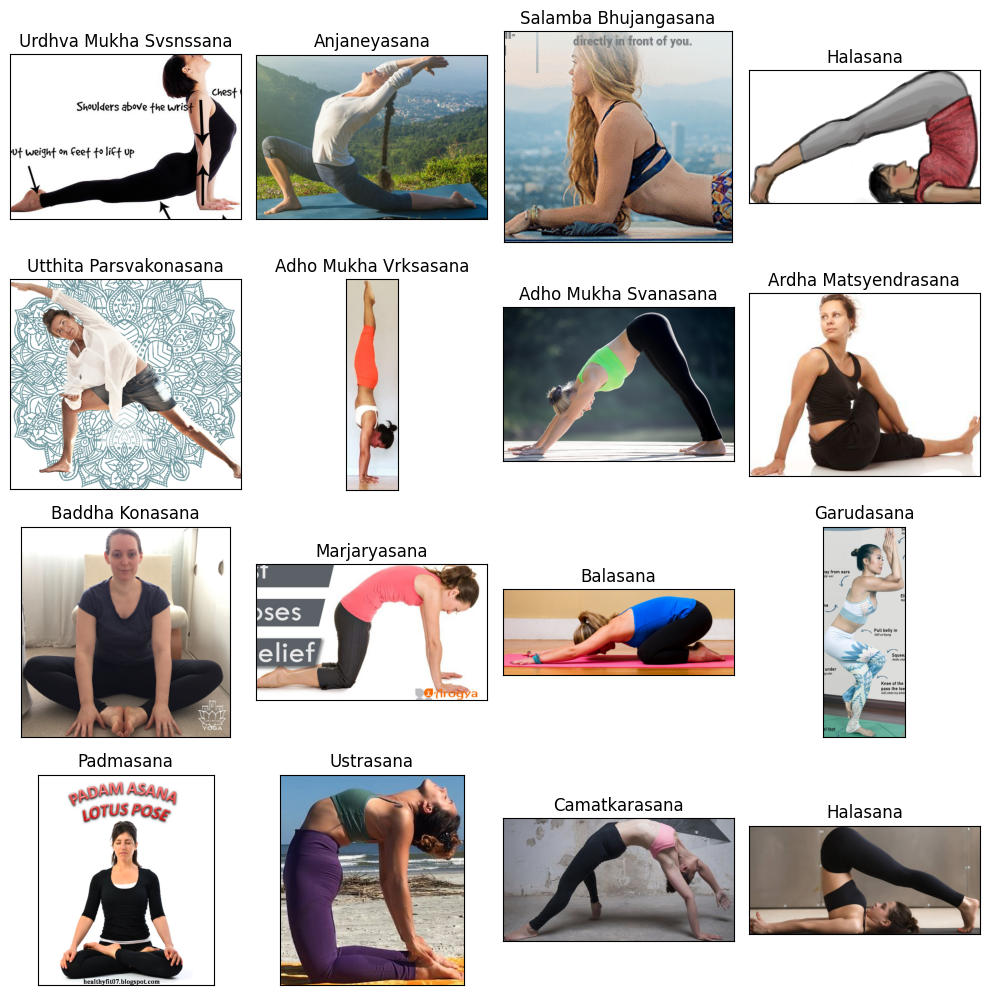

In [ ]:
# Display 9 picture of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

# Computing Error Rate Analysis

In [ ]:
def compute_ela_cv(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    SCALE = 15
    orig_img = cv2.imread(path)
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)

    cv2.imwrite(temp_filename, orig_img, [cv2.IMWRITE_JPEG_QUALITY, quality])

    # read compressed image
    compressed_img = cv2.imread(temp_filename)

    # get absolute difference between img1 and img2 and multiply by scale
    diff = SCALE * cv2.absdiff(orig_img, compressed_img)
    return diff

In [ ]:
from PIL import Image, ImageChops, ImageEnhance
def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    ela_filename = 'temp_ela.png'
    image = Image.open(path).convert('RGBA')
    image.save(temp_filename, 'RGBA', quality = quality)
    temp_image = Image.open(temp_filename)

    ela_image = ImageChops.difference(image, temp_image)

    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1

    scale = 255.0 / max_diff
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)

    return ela_image

In [ ]:
def random_sample(path, extension=None):
    if extension:
        items = Path(path).glob(f'*.{extension}')
    else:
        items = Path(path).glob(f'*')

    items = list(items)

    p = random.choice(items)
    return p.as_posix()

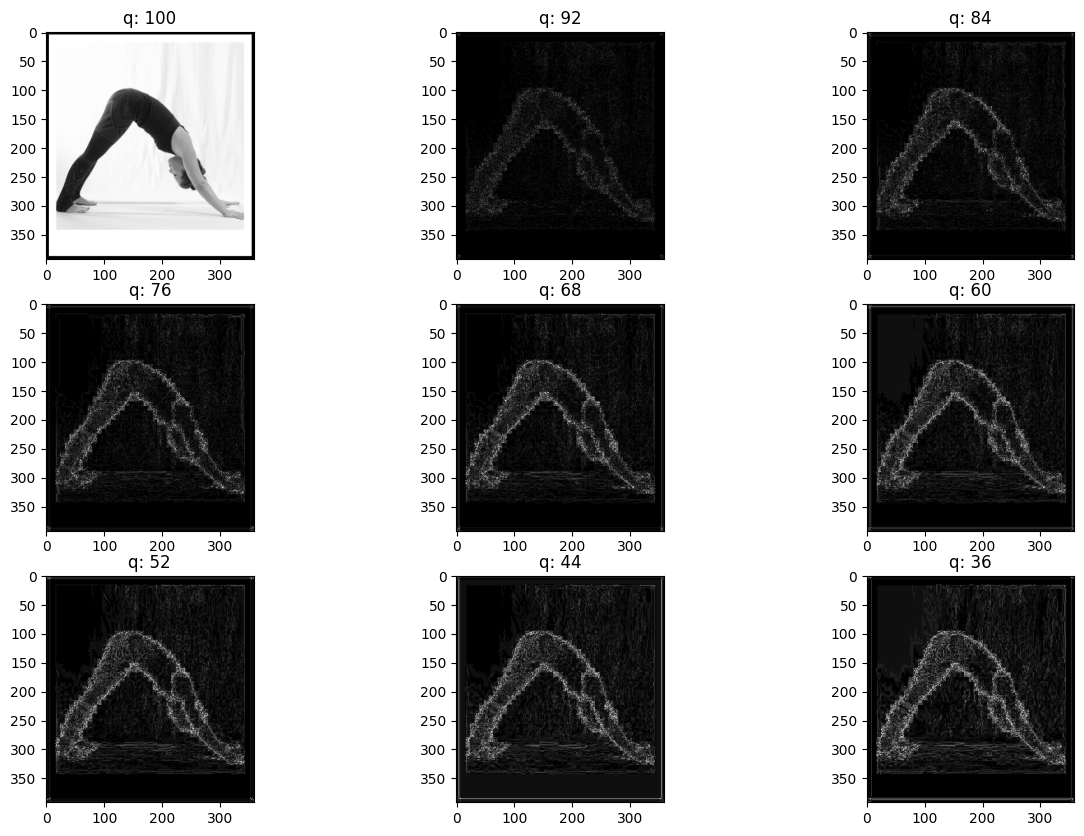

In [ ]:
# View random sample from the dataset
p = random_sample(path+'/Adho Mukha Svanasana')
orig = cv2.imread(p)
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB) / 255.0
init_val = 100
columns = 3
rows = 3

fig=plt.figure(figsize=(15, 10))
for i in range(1, columns*rows +1):
    quality=init_val - (i-1) * 8
    img = compute_ela_cv(path=p, quality=quality)
    if i == 1:
        img = orig.copy()
    ax = fig.add_subplot(rows, columns, i)
    ax.title.set_text(f'q: {quality}')
    plt.imshow(img)
plt.show()

# Data Preprocessing

The data will be split into three different categories: Training, Validation and Testing. The training data will be used to train the deep learning CNN model and its parameters will be fine tuned with the validation data. Finally, the performance of the data will be evaluated using the test data(data the model has not previously seen).

In [ ]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=501)

In [ ]:
train_df

Filepath  \
221   /content/drive/MyDrive/yoga_pose_dataset/Eka P...   
3439  /content/drive/MyDrive/yoga_pose_dataset/Baddh...   
4513  /content/drive/MyDrive/yoga_pose_dataset/Adho ...   
3110  /content/drive/MyDrive/yoga_pose_dataset/Pinch...   
549   /content/drive/MyDrive/yoga_pose_dataset/Alana...   
...                                                 ...   
1526  /content/drive/MyDrive/yoga_pose_dataset/Anjan...   
4036  /content/drive/MyDrive/yoga_pose_dataset/Malas...   
591   /content/drive/MyDrive/yoga_pose_dataset/Virab...   
2727  /content/drive/MyDrive/yoga_pose_dataset/Urdhv...   
671   /content/drive/MyDrive/yoga_pose_dataset/Halas...   

                        Label  
221   Eka Pada Rajakapotasana  
3439          Baddha Konasana  
4513     Adho Mukha Svanasana  
3110        Pincha Mayurasana  
549                 Alanasana  
...                       ...  
1526             Anjaneyasana  
4036                 Malasana  
591        Virabhadrasana One  
2727   Urdhva Mukha Svsnssana  
671                  Halasana  

[3735 rows x 2 columns]

In [ ]:
test_df

Filepath  \
2250  /content/drive/MyDrive/yoga_pose_dataset/Padma...   
136   /content/drive/MyDrive/yoga_pose_dataset/Virab...   
4187  /content/drive/MyDrive/yoga_pose_dataset/Uttan...   
841   /content/drive/MyDrive/yoga_pose_dataset/Urdhv...   
2284  /content/drive/MyDrive/yoga_pose_dataset/Phala...   
...                                                 ...   
1141  /content/drive/MyDrive/yoga_pose_dataset/Baddh...   
3037  /content/drive/MyDrive/yoga_pose_dataset/Setu ...   
2134  /content/drive/MyDrive/yoga_pose_dataset/Ustra...   
1767  /content/drive/MyDrive/yoga_pose_dataset/Malas...   
3526  /content/drive/MyDrive/yoga_pose_dataset/Vasis...   

                         Label  
2250                 Padmasana  
136         Virabhadrasana Two  
4187                Uttanasana  
841         Urdhva Dhanurasana  
2284               Phalakasana  
...                        ...  
1141           Baddha Konasana  
3037  Setu Bandha Sarvangasana  
2134                 Ustrasana  
1767                  Malasana  
3526              Vasisthasana  

[934 rows x 2 columns]

In [ ]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input
)

In [ ]:
# Split the data into three categories.
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 2988 validated image filenames belonging to 43 classes.
Found 747 validated image filenames belonging to 43 classes.
Found 934 validated image filenames belonging to 43 classes.


In [ ]:
print(train_images.n)
print(val_images.n)
print(test_images.n)

print(train_images.batch_size)
print(val_images.batch_size)
print(test_images.batch_size)

print(len(train_images))
print(len(val_images))
print(len(test_images))

2988
747
934
32
32
32
94
24
30


In [ ]:
print(train_images.class_indices)
print(val_images.class_indices)
print(test_images.class_indices)

{'Adho Mukha Svanasana': 0, 'Adho Mukha Vrksasana': 1, 'Alanasana': 2, 'Anjaneyasana': 3, 'Ardha Chandrasana': 4, 'Ardha Matsyendrasana': 5, 'Ardha Navasana': 6, 'Ardha Pincha Mayurasana': 7, 'Ashta Chandrasana': 8, 'Baddha Konasana': 9, 'Bakasana': 10, 'Balasana': 11, 'Bitilasana': 12, 'Camatkarasana': 13, 'Dhanurasana': 14, 'Eka Pada Rajakapotasana': 15, 'Garudasana': 16, 'Halasana': 17, 'Hanumanasana': 18, 'Malasana': 19, 'Marjaryasana': 20, 'Padmasana': 21, 'Parsvottanasana': 22, 'Paschimottanasana': 23, 'Phalakasana': 24, 'Pincha Mayurasana': 25, 'Salamba Bhujangasana': 26, 'Salamba Sarvangasana': 27, 'Setu Bandha Sarvangasana': 28, 'Sivasana': 29, 'Supta Kapotasana': 30, 'Urdhva Dhanurasana': 31, 'Urdhva Mukha Svsnssana': 32, 'Ustrasana': 33, 'Utkatasana': 34, 'Uttanasana': 35, 'Utthita Hasta Padangusthasana': 36, 'Utthita Parsvakonasana': 37, 'Vasisthasana': 38, 'Virabhadrasana One': 39, 'Virabhadrasana Three': 40, 'Virabhadrasana Two': 41, 'Vrksasana': 42}
{'Adho Mukha Svanasan

In [ ]:
# Resize Layer
resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.Resizing(224,224),
  tf.keras.layers.Rescaling(1./255),
])

# Setup data augmentation
data_augmentation = keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(0.2),
  tf.keras.layers.RandomHeight(0.2),
  tf.keras.layers.RandomWidth(0.2),
], name="data_augmentation")

# Training the model

The model images will be subjected to a pre-trained CNN model called MobileNetV3Large. Three callbacks will be utilized to monitor the training. These are: Model Checkpoint, Early Stopping, Tensorboard callback. The summary of the model hyperparameter is shown as follows:

Batch size : 32

Epochs : 100

Input Shape : (224, 224, 3)

Output layer : 43

In [ ]:
# Load the pretained model
pretrained_model = tf.keras.applications.MobileNetV3Large(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg',
)

pretrained_model.trainable = False

In [ ]:
# Create checkpoint callback
checkpoint_path = "yoga_classification_model_checkpoint.weights.h5"
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

In [ ]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=30,
                                                  restore_best_weights=True) # if val loss decreases for 3 epochs in a row, stop training
# l loss decreases for 3 epochs in a row, stop training

In [ ]:
print(pretrained_model.summary())

Model: "MobileNetV3Large"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv (Conv2D)             │ (None, 112, 112, 16)   │            432 │ rescaling_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_bn                   │ (None, 112, 112, 16)   │             64 │ conv[0][0]             │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 112, 112, 16)   │              0 │ conv_bn[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 16)   │            144 │ activation[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 16)   │             64 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 112, 112, 16)   │              0 │ expanded_conv_depthwi… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            256 │ re_lu[0][0]            │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_bn  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_add (Add)   │ (None, 112, 112, 16)   │              0 │ activation[0][0],      │
│                           │                        │                │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_1_expand    │ (None, 112, 112, 64)   │          1,024 │ expanded_conv_add[0][… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_1_expand_bn │ (None, 112, 112, 64)   │            256 │ expanded_conv_1_expan… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 112, 112, 64)   │              0 │ expanded_conv_1_expan… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_1_depthwis… │ (None, 113, 113, 64)   │              0 │ re_lu_1[0][0]          │
│ (ZeroPadding2D)           │                        │                │                        │
├──────────────────────

 Total params: 2,996,352 (11.43 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,996,352 (11.43 MB)

None


In [ ]:
pretrained_model.input

<KerasTensor shape=(None, 224, 224, 3), dtype=float32, sparse=False, name=keras_tensor>

In [ ]:
pretrained_model.output

<KerasTensor shape=(None, 960), dtype=float32, sparse=False, name=keras_tensor_203>

# Train the model

In [ ]:
inputs = pretrained_model.input
print(inputs)
x = resize_and_rescale(inputs)
print(x)
x = data_augmentation(x)
print(x)
x = Dense(256, activation='relu')(pretrained_model.output)
print(x)
x = Dropout(0.2)(x)
print(x)
x = Dense(256, activation='relu')(x)
print(x)
x = Dropout(0.2)(x)
print(x)

outputs = Dense(43, activation='softmax')(x)
print(outputs)
model = Model(inputs=inputs, outputs=outputs)
print(model)

model.compile(
    optimizer=Adam(0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=100,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs",
                                    "yoga_classification"),
        checkpoint_callback,
    ]
)

<KerasTensor shape=(None, 224, 224, 3), dtype=float32, sparse=False, name=keras_tensor>
<KerasTensor shape=(None, 224, 224, 3), dtype=float32, sparse=False, name=keras_tensor_207>
<KerasTensor shape=(None, None, None, 3), dtype=float32, sparse=False, name=keras_tensor_214>
<KerasTensor shape=(None, 256), dtype=float32, sparse=False, name=keras_tensor_215>
<KerasTensor shape=(None, 256), dtype=float32, sparse=False, name=keras_tensor_216>
<KerasTensor shape=(None, 256), dtype=float32, sparse=False, name=keras_tensor_217>
<KerasTensor shape=(None, 256), dtype=float32, sparse=False, name=keras_tensor_218>
<KerasTensor shape=(None, 43), dtype=float32, sparse=False, name=keras_tensor_219>
<Functional name=functional_2, built=True>
Saving TensorBoard log files to: training_logs/yoga_classification/20241206-214056
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


74/94 ━━━━━━━━━━━━━━━━━━━━ 59s 3s/step - accuracy: 0.0296 - loss: 4.0746 

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


94/94 ━━━━━━━━━━━━━━━━━━━━ 460s 5s/step - accuracy: 0.0301 - loss: 4.0650 - val_accuracy: 0.0321 - val_loss: 3.8292
Epoch 2/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 29s 290ms/step - accuracy: 0.0440 - loss: 3.9114 - val_accuracy: 0.0402 - val_loss: 3.7540
Epoch 3/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 29s 288ms/step - accuracy: 0.0456 - loss: 3.8287 - val_accuracy: 0.0415 - val_loss: 3.6957
Epoch 4/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 29s 289ms/step - accuracy: 0.0385 - loss: 3.8007 - val_accuracy: 0.0428 - val_loss: 3.6487
Epoch 5/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 28s 285ms/step - accuracy: 0.0509 - loss: 3.7159 - val_accuracy: 0.0442 - val_loss: 3.6055
Epoch 6/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 29s 285ms/step - accuracy: 0.0584 - loss: 3.6775 - val_accuracy: 0.0589 - val_loss: 3.5655
Epoch 7/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 28s 286ms/step - accuracy: 0.0652 - loss: 3.6282 - val_accuracy: 0.0696 - val_loss: 3.5278
Epoch 8/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 29s 288ms/step - accuracy: 0.0680 - loss: 3.5922 - val_accuracy: 

In [ ]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv (Conv2D)             │ (None, 112, 112, 16)   │            432 │ rescaling_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_bn                   │ (None, 112, 112, 16)   │             64 │ conv[0][0]             │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 112, 112, 16)   │              0 │ conv_bn[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 16)   │            144 │ activation[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 16)   │             64 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 112, 112, 16)   │              0 │ expanded_conv_depthwi… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            256 │ re_lu[0][0]            │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_bn  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_add (Add)   │ (None, 112, 112, 16)   │              0 │ activation[0][0],      │
│                           │                        │                │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_1_expand    │ (None, 112, 112, 64)   │          1,024 │ expanded_conv_add[0][… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_1_expand_bn │ (None, 112, 112, 64)   │            256 │ expanded_conv_1_expan… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 112, 112, 64)   │              0 │ expanded_conv_1_expan… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_1_depthwis… │ (None, 113, 113, 64)   │              0 │ re_lu_1[0][0]          │
│ (ZeroPadding2D)           │                        │                │                        │
├──────────────────────

 Total params: 3,964,931 (15.13 MB)

 Trainable params: 322,859 (1.23 MB)

 Non-trainable params: 2,996,352 (11.43 MB)

 Optimizer params: 645,720 (2.46 MB)

In [ ]:
history.history

{'accuracy': [0.03145917132496834,
  0.040829986333847046,
  0.036813922226428986,
  0.044846050441265106,
  0.05321285128593445,
  0.05957162007689476,
  0.06559571623802185,
  0.06559571623802185,
  0.08567603677511215,
  0.0940428376197815,
  0.09973226487636566,
  0.10374832898378372,
  0.12449799478054047,
  0.13922356069087982,
  0.1405622512102127,
  0.15963855385780334,
  0.17503346502780914,
  0.1820615828037262,
  0.18607763946056366,
  0.2098393589258194,
  0.2299196720123291,
  0.22556893527507782,
  0.240629181265831,
  0.2610441744327545,
  0.28614458441734314,
  0.2888219654560089,
  0.3055555522441864,
  0.30923694372177124,
  0.32463186979293823,
  0.32797858119010925,
  0.33701473474502563,
  0.36512717604637146,
  0.3731592893600464,
  0.3778447210788727,
  0.3868808448314667,
  0.39123159646987915,
  0.41599732637405396,
  0.42536813020706177,
  0.42034804821014404,
  0.44678714871406555,
  0.4431057572364807,
  0.46084338426589966,
  0.4615127146244049,
  0.4658634

# Model Evaluation

The test dataset will be used to evaluate the performance of the model.One of the metrics that will be tested would be accuracy which measures the fraction of predictions the model got right. Other metrics are as follows:

Precision(P):
The fraction of true positives (TP, correct predictions) from the total amount of relevant results, i.e., the sum of TP and false positives (FP). For multi-class classification problems, P is averaged among the classes. The following is the formula for precision.


P
=
T
P
/
(
T
P
+
F
P
)


Recall(R):
The fraction of TP from the total amount of TP and false negatives (FN). For multi-class classification problems, R gets averaged among all the classes. The following is the formula for recall.


R
=
T
P
/
(
T
P
+
F
N
)


F1 score(F1):
The harmonic mean of precision and recall. For multi-class classification problems, F1 gets averaged among all the classes. The following is the formula for F1 score.


F
1
=
2
∗
(
T
P
∗
F
P
)
/
(
T
P
+
F
P
)



In [ ]:
results = model.evaluate(test_images, verbose=0)

print("Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

Test Loss: 0.97776
Test Accuracy: 78.16%


# Visualizing loss curves

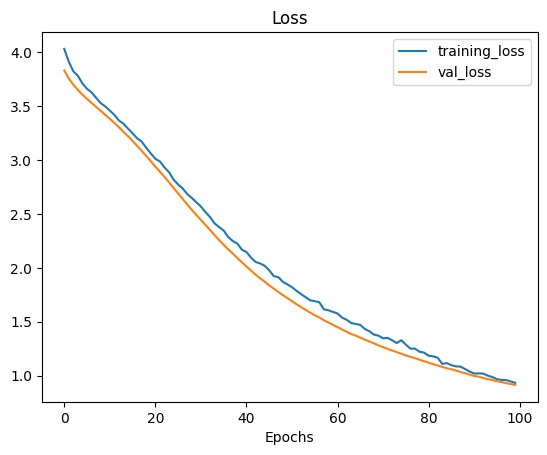

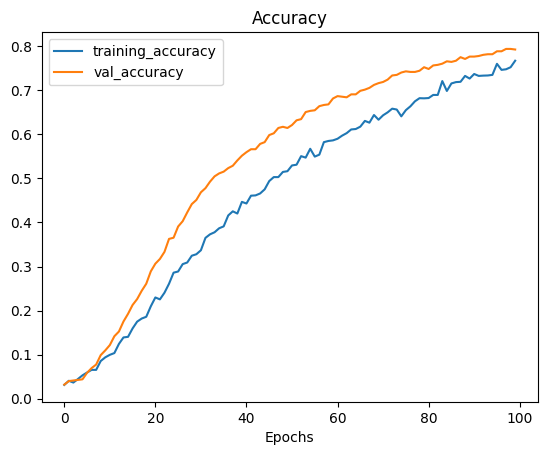

In [ ]:
plot_loss_curves(history)

# Making predictions on the test data

In [ ]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

30/30 ━━━━━━━━━━━━━━━━━━━━ 16s 376ms/step
The first 5 predictions: ['Padmasana', 'Utthita Hasta Padangusthasana', 'Uttanasana', 'Urdhva Dhanurasana', 'Phalakasana']


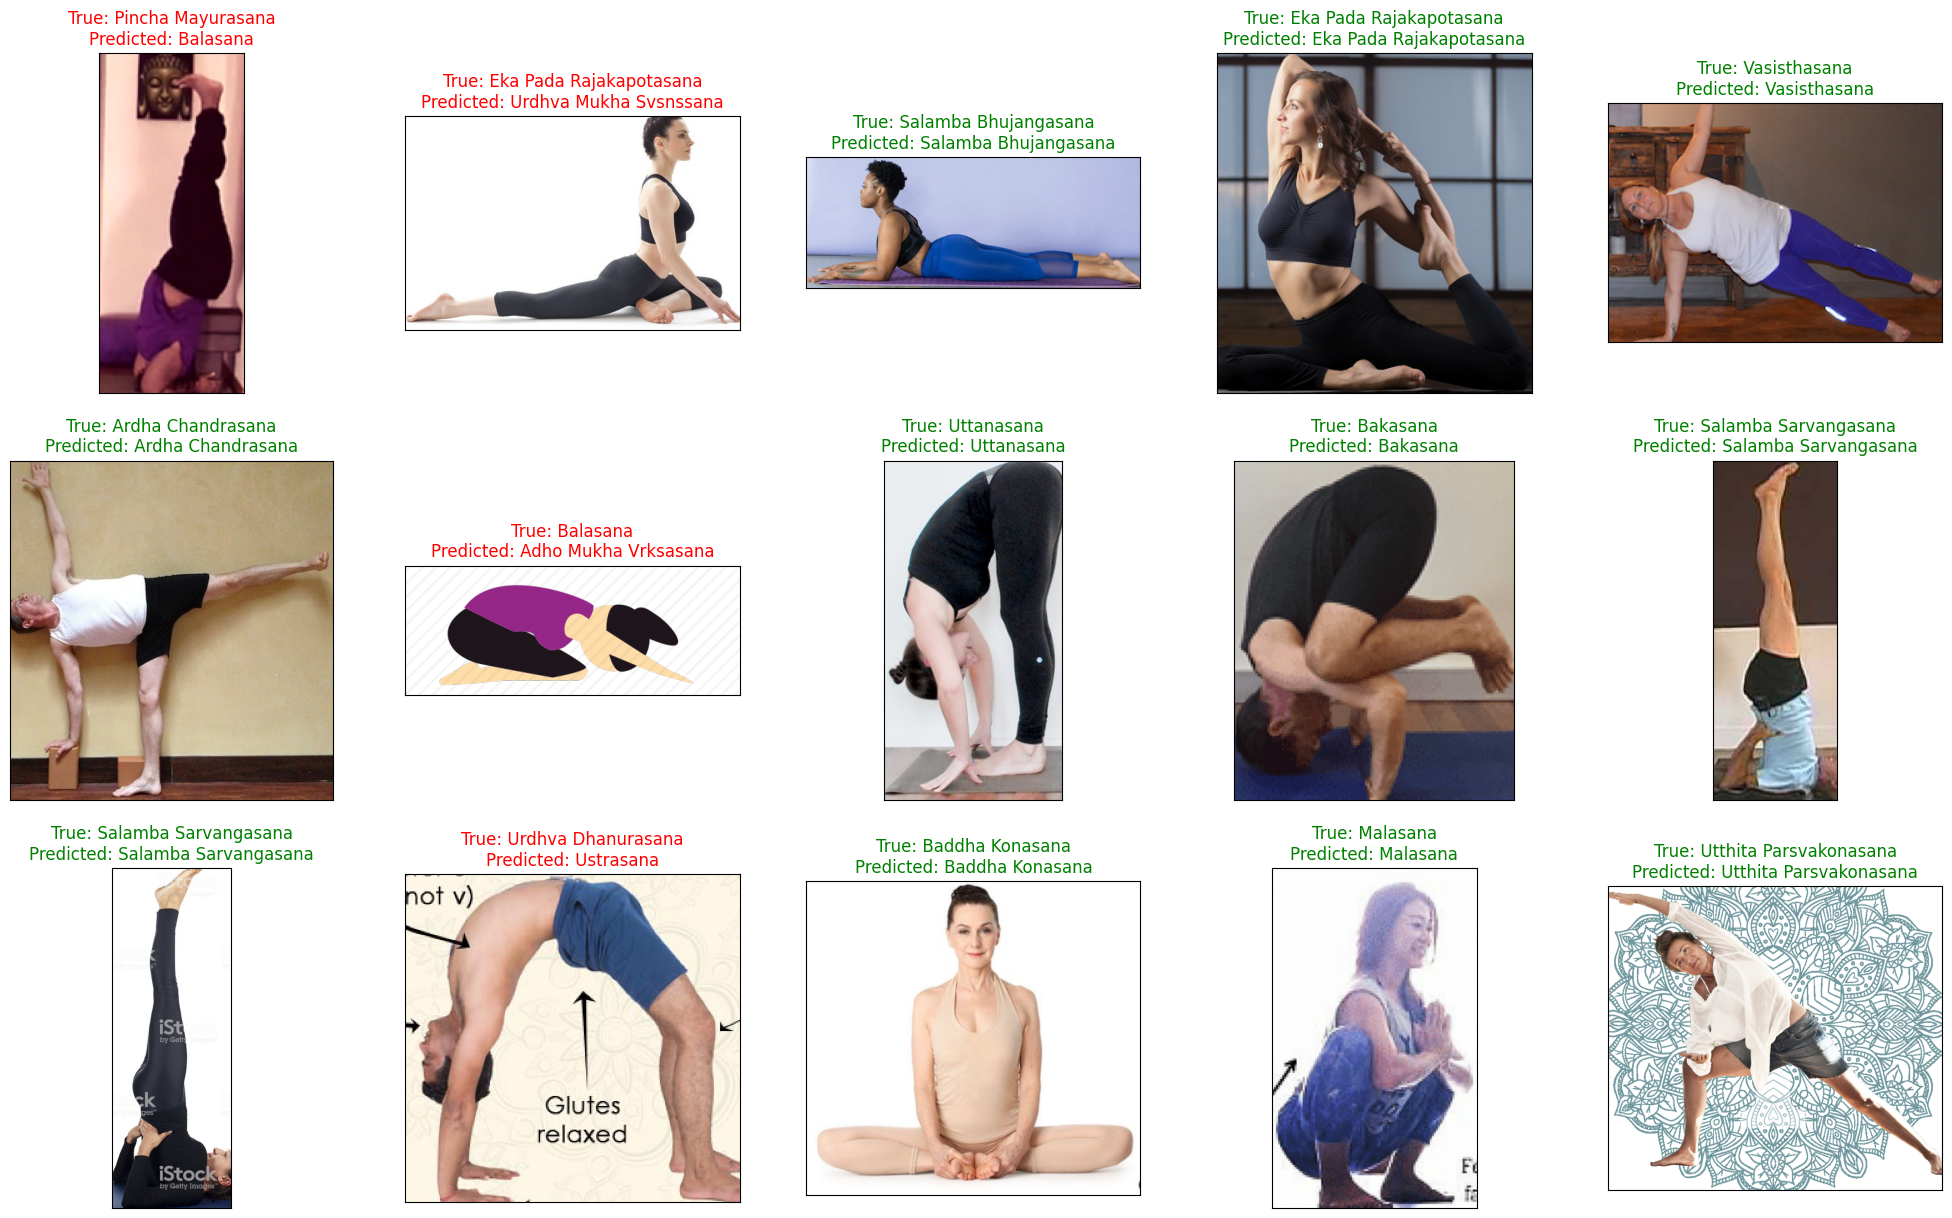

<Figure size 640x480 with 0 Axes>

In [ ]:
 # Display 15 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
      color = "green"
    else:
      color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

# Plotting the classification reports and confusion matrix

In [ ]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

                               precision    recall  f1-score   support

         Adho Mukha Svanasana       0.76      0.81      0.79        27
         Adho Mukha Vrksasana       0.63      0.74      0.68        23
                    Alanasana       0.00      0.00      0.00         3
                 Anjaneyasana       0.69      0.78      0.73        23
            Ardha Chandrasana       0.76      0.73      0.74        22
         Ardha Matsyendrasana       0.84      0.95      0.89        38
               Ardha Navasana       0.00      0.00      0.00         3
      Ardha Pincha Mayurasana       0.91      0.56      0.69        18
            Ashta Chandrasana       0.00      0.00      0.00         1
              Baddha Konasana       0.90      0.75      0.82        24
                     Bakasana       0.73      0.91      0.81        33
                     Balasana       0.69      0.74      0.71        27
                   Bitilasana       0.79      0.90      0.84        30
     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


precision    recall  f1-score     support
Adho Mukha Svanasana            0.758621  0.814815  0.785714   27.000000
Adho Mukha Vrksasana            0.629630  0.739130  0.680000   23.000000
Alanasana                       0.000000  0.000000  0.000000    3.000000
Anjaneyasana                    0.692308  0.782609  0.734694   23.000000
Ardha Chandrasana               0.761905  0.727273  0.744186   22.000000
Ardha Matsyendrasana            0.837209  0.947368  0.888889   38.000000
Ardha Navasana                  0.000000  0.000000  0.000000    3.000000
Ardha Pincha Mayurasana         0.909091  0.555556  0.689655   18.000000
Ashta Chandrasana               0.000000  0.000000  0.000000    1.000000
Baddha Konasana                 0.900000  0.750000  0.818182   24.000000
Bakasana                        0.731707  0.909091  0.810811   33.000000
Balasana                        0.689655  0.740741  0.714286   27.000000
Bitilasana                      0.794118  0.900000  0.843750   30.000000
Camatkarasana                   0.700000  0.913043  0.792453   23.000000
Dhanurasana                     0.928571  0.684211  0.787879   19.000000
Eka Pada Rajakapotasana         0.875000  0.736842  0.800000   19.000000
Garudasana                      0.807692  0.750000  0.777778   28.000000
Halasana                        0.750000  0.964286  0.843750   28.000000
Hanumanasana                    0.923077  0.631579  0.750000   19.000000
Malasana                        0.851852  0.851852  0.851852   27.000000
Marjaryasana                    0.888889  0.444444  0.592593   18.000000
Padmasana                       0.923077  0.888889  0.905660   27.000000
Parsvottanasana                 0.545455  0.857143  0.666667    7.000000
Paschimottanasana               0.666667  0.736842  0.700000   19.000000
Phalakasana                     0.857143  0.720000  0.782609   25.000000
Pincha Mayurasana               1.000000  0.428571  0.600000   14.000000
Salamba Bhujangasana            0.666667  0.700000  0.682927   20.000000
Salamba Sarvangasana            0.857143  0.827586  0.842105   29.000000
Setu Bandha Sarvangasana        0.944444  0.944444  0.944444   18.000000
Sivasana                        0.000000  0.000000  0.000000    1.000000
Supta Kapotasana                1.000000  1.000000  1.000000    2.000000
Urdhva Dhanurasana              0.909091  0.512821  0.655738   39.000000
Urdhva Mukha Svsnssana          0.655172  0.863636  0.745098   22.000000
Ustrasana                       0.666667  0.800000  0.727273   20.000000
Utkatasana                      0.600000  0.913043  0.724138   23.000000
Uttanasana                      0.666667  0.875000  0.756757   16.000000
Utthita Hasta Padangusthasana   0.838710  0.838710  0.838710   31.000000
Utthita Parsvakonasana          0.814815  0.814815  0.814815   27.000000
Vasisthasana                    0.676471  0.696970  0.686567   33.000000
Virabhadrasana One              0.782609  0.720000  0.750000   25.000000
Virabhadrasana Three            0.869565  0.833333  0.851064   24.000000
Virabhadrasana Two              0.862069  0.892857  0.877193   28.000000
Vrksasana                       0.933333  0.903226  0.918033   31.000000
accuracy                        0.781585  0.781585  0.781585    0.781585
macro avg                       0.724769  0.711877  0.706425  934.000000
weighted avg                    0.792360  0.781585  0.775818  934.000000

# Grad-Cam Visualization

In [ ]:
def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size "size"
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):

    # print("Shape of img_array:", img_array.shape)
    # print("Shape of last_conv_layer_output:", model.get_layer(last_conv_layer_name).output.shape)

    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
#     display(Image(cam_path))

    return cam_path


preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

# last_conv_layer_name = "Conv_1"
last_conv_layer_name = "conv_1"
img_size = (224,224, 3)

# Remove last layer's softmax
model.layers[-1].activation = None

<ipython-input-45-92c32820f7ef>:55: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


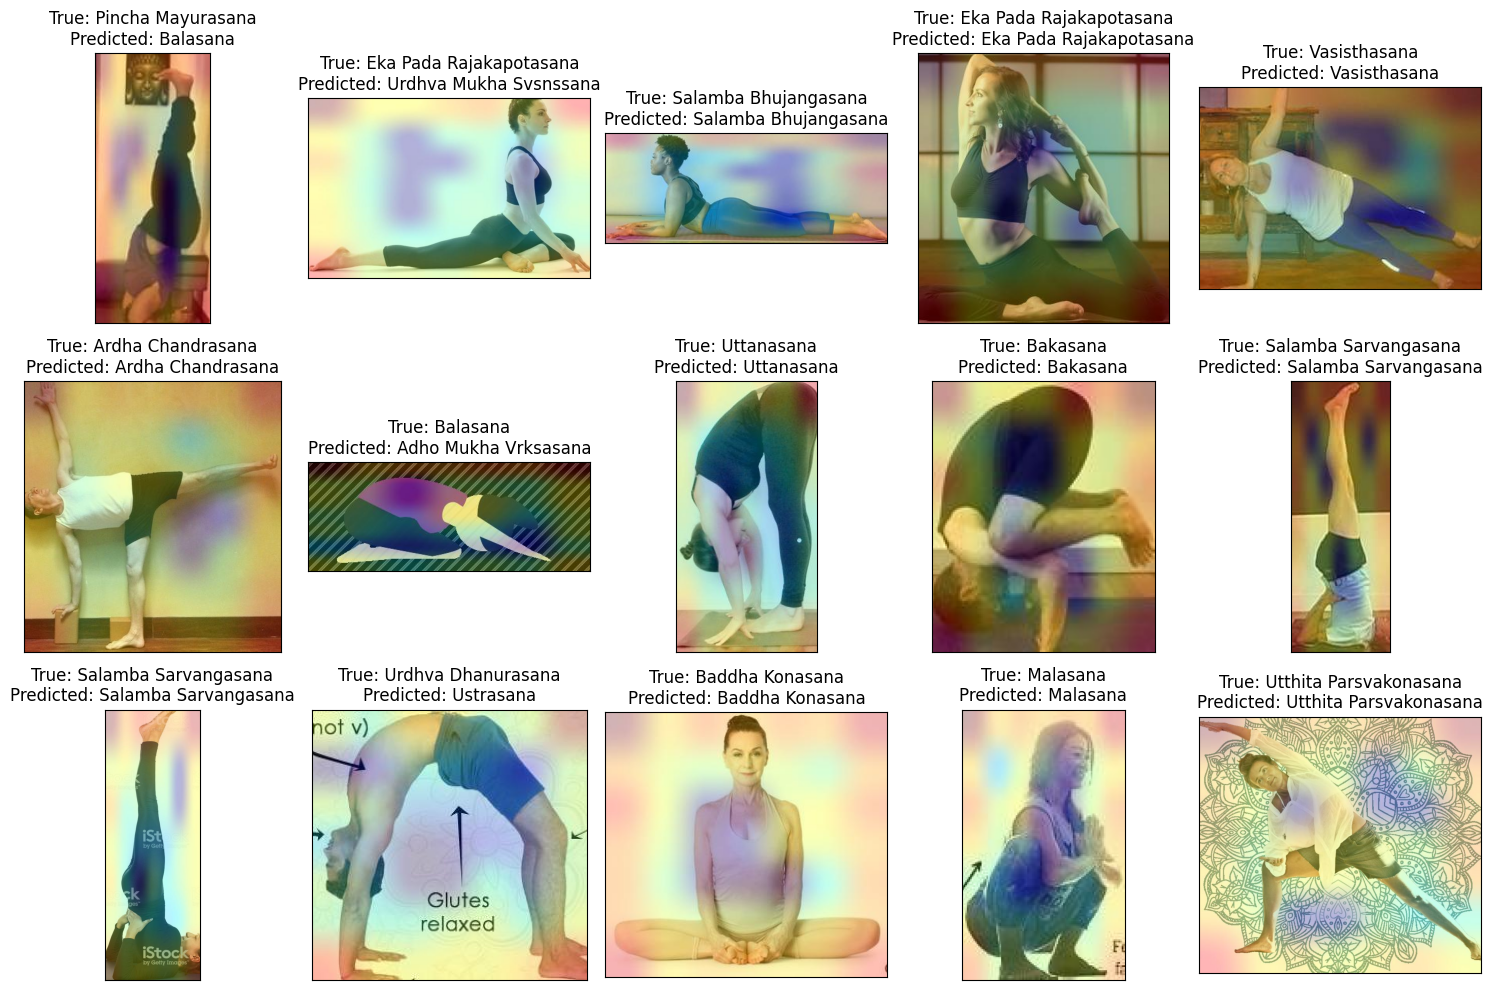

In [ ]:
# Display the part of the pictures used by the neural network to classify the pictures
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img_path = test_df.Filepath.iloc[random_index[i]]
    img_array = preprocess_input(get_img_array(img_path, size=img_size))
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    cam_path = save_and_display_gradcam(img_path, heatmap)
    ax.imshow(plt.imread(cam_path))
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}")
plt.tight_layout()
plt.show()